In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline
import cv2
import random
from PIL import Image
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, GlobalMaxPooling2D, Dropout
from keras.models import Model
from keras import optimizers
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

In [3]:
DATA_DIR = '../input/large-gender-face-dataset/big_face_gender_data'
print(os.listdir(path=DATA_DIR))

['Validation', 'Test', 'Train']


In [4]:
# Use ImageDataGenerator to process input data, attach labels, and prevent overflow ram during training

batch_size = 512
image_shape = (218,178)

def add_noise(img):
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=20,shear_range=0.2,
                                   zoom_range = [0.8, 1.2], horizontal_flip=True,
                                   brightness_range= [0.7, 1.3],width_shift_range=0.2,
                                   height_shift_range=0.2, fill_mode='nearest') #preprocessing_function=add_noise

train = train_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Train',
                                       target_size=image_shape, batch_size=batch_size,
                                       class_mode='binary', color_mode='rgb', shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
val = validation_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Validation',
                                          target_size=image_shape, batch_size=batch_size,
                                          class_mode='binary', color_mode='rgb', shuffle=True)

Found 181665 images belonging to 2 classes.
Found 17765 images belonging to 2 classes.


In [5]:
img, label = train.next()
print(img[1].shape)

(218, 178, 3)


In [6]:
print('Len(train):',len(train))
print('len(val):', len(val))

Len(train): 355
len(val): 35


In [7]:
print(train.class_indices)
train.classes

{'Female': 0, 'Male': 1}


array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

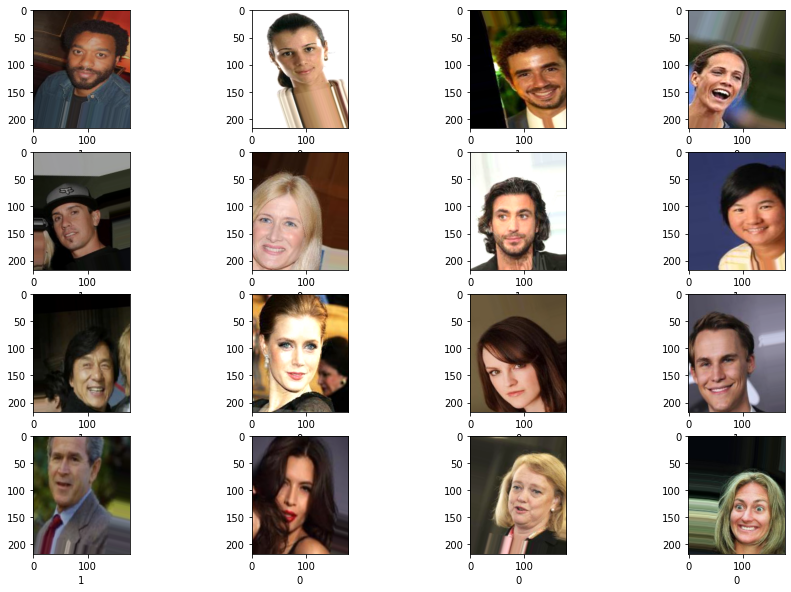

In [8]:
# Show image
img, label = train.next()

fig = plt.figure(figsize=(15,10))
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(img[i])
    plt.xlabel( int(label[i]))
plt.show()

# Build Model EfficientNet B0

In [10]:
input_shape = (218, 178, 3)
pre_trained_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=input_shape,
                                                                      include_top=False,
                                                                      weights="imagenet")
for i,layer in enumerate(pre_trained_model.layers):
    print(i,layer.name)
print("\nInput:", pre_trained_model.input)
print("Output:", pre_trained_model.output)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

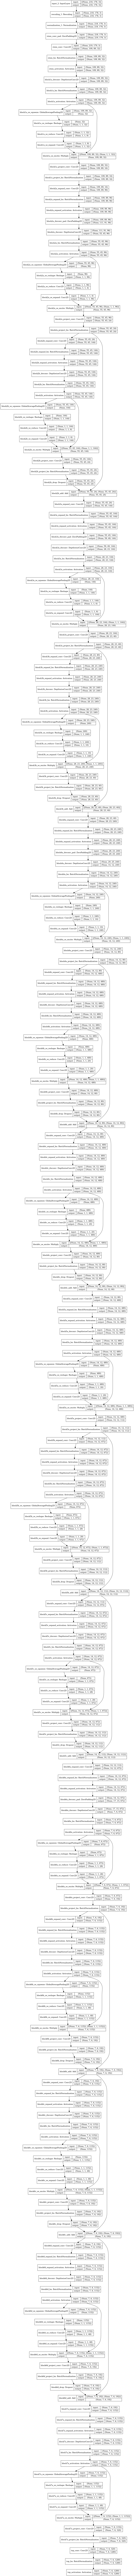

In [11]:
# Visualation architecture
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

# Train Model

In [12]:
input_shape = (218, 178, 3)

pre_trained_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=input_shape,
                                                                      include_top=False,
                                                                      weights="imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = False
last_output = pre_trained_model.output
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)  # Dropout layer to reduce overfitting
# Add a final sigmoid layer for classification
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=pre_trained_model.input, outputs=x)
    
model.compile(keras.optimizers.Adagrad(learning_rate=0.001), 
              loss = 'binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 218, 178, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 218, 178, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 219, 179, 3)  0           normalization_2[0][0]            
______________________________________________________________________________________________

In [5]:
checkpoint = ModelCheckpoint('training_save.h5', verbose=1, mode='auto',
                                              monitor='val_accuracy',  
                                              save_best_only=True)

history = model.fit_generator(
    train, epochs=20,
    validation_data=val,
    verbose=1, callbacks=[checkpoint])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-10-28 08:31:19.042398: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-10-28 08:31:29.581615: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 60/355 [====>.........................] - ETA: 18:37 - loss: 1.0588 - accuracy: 0.5006

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


355/355 [==============================] - 1578s 4s/step - loss: 0.8218 - accuracy: 0.5008 - val_loss: 0.6925 - val_accuracy: 0.5035

Epoch 00001: val_accuracy improved from -inf to 0.50352, saving model to training_save.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
355/355 [==============================] - 895s 3s/step - loss: 0.7101 - accuracy: 0.5031 - val_loss: 0.6912 - val_accuracy: 0.5040

Epoch 00002: val_accuracy improved from 0.50352 to 0.50402, saving model to training_save.h5
Epoch 3/20
355/355 [==============================] - 824s 2s/step - loss: 0.7000 - accuracy: 0.5062 - val_loss: 0.6937 - val_accuracy: 0.5035

Epoch 00003: val_accuracy did not improve from 0.50402
Epoch 4/20
355/355 [==============================] - 824s 2s/step - loss: 0.6969 - accuracy: 0.5077 - val_loss: 0.6909 - val_accuracy: 0.5085

Epoch 00004: val_accuracy improved from 0.50402 to 0.50853, saving model to training_save.h5
Epoch 5/20
355/355 [==============================] - 839s 2s/step - loss: 0.6954 - accuracy: 0.5126 - val_loss: 0.6916 - val_accuracy: 0.5035

Epoch 00005: val_accuracy did not improve from 0.50853
Epoch 6/20
355/355 [==============================] - 797s 2s/step - loss: 0.6948 - accuracy: 0.5117 - val_loss: 0.6915 - val_ac

In [12]:
np.save('efficient_history.npy',history.history)

In [ ]:
print(history.history.keys())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()


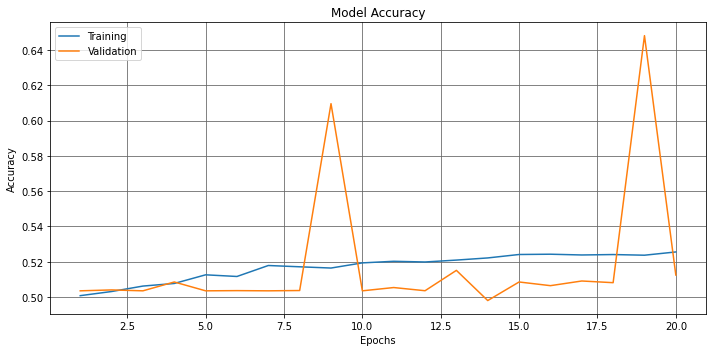

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


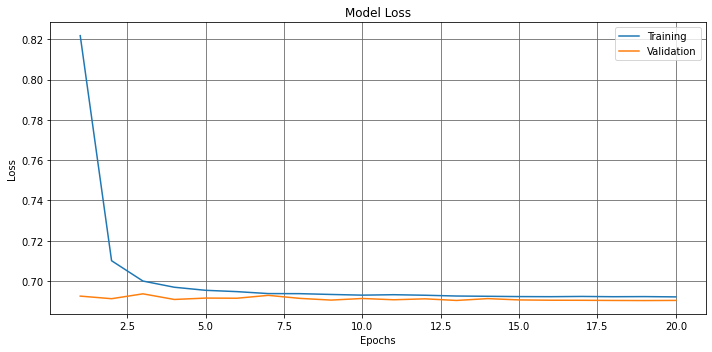

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

In [ ]:
history=np.load('../input/my-data/my_history.npy',allow_pickle='TRUE').item()
history

In [ ]:
acc = history.get('accuracy')
val_acc = history.get('val_accuracy')
loss = history.get('loss')
val_loss = history.get('val_loss')

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

# Evaluation on test set

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Test',
                                          target_size=(218,178), batch_size=32,
                                          class_mode='binary', color_mode='rgb', shuffle=False)

Found 16779 images belonging to 2 classes.


In [9]:
predictions = []
labels = []
for i in range(len(test)):
    x, y = next(test)
    pre = model.predict(x)
    pre = [1 if x > 0.5 else 0 for x in pre]
    predictions.append(pre)
    labels.append(y)
predictions = np.concatenate(predictions)
labels = np.concatenate(labels)
print(len(predictions))

16779


              precision    recall  f1-score   support

         0.0       0.50      0.98      0.66      8320
         1.0       0.62      0.04      0.07      8459

    accuracy                           0.50     16779
   macro avg       0.56      0.51      0.37     16779
weighted avg       0.56      0.50      0.36     16779

Confusion matrix, without normalization
[[8126  194]
 [8139  320]]


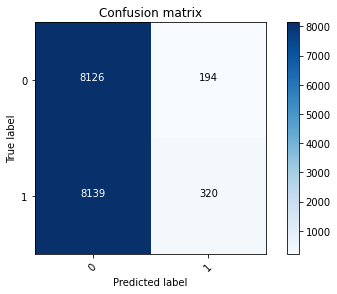

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   
#--------------------------------------------------------------------------------------------------
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, predictions, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(labels, predictions))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],normalize= False,  title='Confusion matrix')

In [11]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


# Tính accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(labels, predictions)
print('Accuracy: %f' % accuracy)
# Tính precision tp / (tp + fp)
precision = precision_score(labels, predictions, average='macro')
print('Precision: %f' % precision)
# Tính recall: tp / (tp + fn)
recall = recall_score(labels, predictions, average='macro')
print('Recall: %f' % recall)
# Tính f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(labels, predictions, average='macro')
print('F1 score: %f' % f1)
# Tính Area under ROC
auc = roc_auc_score(labels, predictions, multi_class='ovr')
print('ROC AUC: %f' % auc)

Accuracy: 0.503367
Precision: 0.561084
Recall: 0.507256
F1 score: 0.366189
ROC AUC: 0.507256


In [ ]:
# Saving model
model.save('vgg16_finish.h5')
print('Done! Model Saved!')

In [ ]:
# Load model
from tensorflow import keras
model = keras.models.load_model('../input/my-data/final.h5')